In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline
#A100 80GB

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility # model
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    model = ACANet_PNA(**pub_args, deg=deg).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, squared = True, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [6]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            'aggregators': ['mean', 'min', 'max', 'sum','std'],
            'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [7]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

Processing...
Done!


1125

In [8]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 394.0542 tsm_loss: 349.0950 reg_loss: 44.9591 n_pos_triplets: 183670;  Val: 6.9099 Test: 6.9305
Epoch: 002, Loss: 90.6614 tsm_loss: 53.7538 reg_loss: 36.9076 n_pos_triplets: 178357;  Val: 6.9047 Test: 6.9253
Epoch: 003, Loss: 62.5865 tsm_loss: 33.1065 reg_loss: 29.4800 n_pos_triplets: 167715;  Val: 6.8912 Test: 6.9119
Epoch: 004, Loss: 45.3688 tsm_loss: 23.8154 reg_loss: 21.5534 n_pos_triplets: 167096;  Val: 6.8330 Test: 6.8542
Epoch: 005, Loss: 31.7298 tsm_loss: 17.8995 reg_loss: 13.8303 n_pos_triplets: 168041;  Val: 6.5754 Test: 6.5987
Epoch: 006, Loss: 20.7391 tsm_loss: 13.7370 reg_loss: 7.0021 n_pos_triplets: 166842;  Val: 5.8992 Test: 5.9248
Epoch: 007, Loss: 13.9978 tsm_loss: 11.4535 reg_loss: 2.5443 n_pos_triplets: 165648;  Val: 4.7390 Test: 4.7663
Epoch: 008, Loss: 10.4072 tsm_loss: 9.2469 reg_loss: 1.1603 n_pos_triplets: 163462;  Val: 3.3384 Test: 3.3641
Epoch: 009, Loss: 9.1865 tsm_loss: 7.8539 reg_loss: 1.3325 n_pos_triplets: 167083;  Val: 2.2367 Test: 2.25

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 42.1813 tsm_loss: 1317.0153 reg_loss: 42.1813 n_pos_triplets: 191486;  Val: 6.8327 Test: 6.8533
Epoch: 002, Loss: 31.9725 tsm_loss: 1686.2357 reg_loss: 31.9725 n_pos_triplets: 183065;  Val: 6.8290 Test: 6.8495
Epoch: 003, Loss: 22.2624 tsm_loss: 1694.1155 reg_loss: 22.2624 n_pos_triplets: 183052;  Val: 6.8245 Test: 6.8450
Epoch: 004, Loss: 11.9266 tsm_loss: 1520.6889 reg_loss: 11.9266 n_pos_triplets: 184085;  Val: 6.8174 Test: 6.8380
Epoch: 005, Loss: 3.6463 tsm_loss: 1171.9327 reg_loss: 3.6463 n_pos_triplets: 178441;  Val: 6.7583 Test: 6.7784
Epoch: 006, Loss: 1.0800 tsm_loss: 771.4536 reg_loss: 1.0800 n_pos_triplets: 173999;  Val: 6.0039 Test: 6.0223
Epoch: 007, Loss: 0.8009 tsm_loss: 833.8916 reg_loss: 0.8009 n_pos_triplets: 172987;  Val: 4.8201 Test: 4.8477
Epoch: 008, Loss: 0.6007 tsm_loss: 773.8266 reg_loss: 0.6007 n_pos_triplets: 170140;  Val: 3.6451 Test: 3.6704
Epoch: 009, Loss: 0.5360 tsm_loss: 635.2354 reg_loss: 0.5360 n_pos_triplets: 160007;  Val: 2.8497 T

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 493.6080 tsm_loss: 447.0874 reg_loss: 46.5206 n_pos_triplets: 192075;  Val: 6.9464 Test: 6.8276
Epoch: 002, Loss: 96.3630 tsm_loss: 54.9522 reg_loss: 41.4108 n_pos_triplets: 176068;  Val: 6.9442 Test: 6.8255
Epoch: 003, Loss: 70.0406 tsm_loss: 33.1714 reg_loss: 36.8692 n_pos_triplets: 164890;  Val: 6.9402 Test: 6.8215
Epoch: 004, Loss: 56.0780 tsm_loss: 24.1965 reg_loss: 31.8815 n_pos_triplets: 169844;  Val: 6.9109 Test: 6.7926
Epoch: 005, Loss: 44.8350 tsm_loss: 18.4790 reg_loss: 26.3560 n_pos_triplets: 164376;  Val: 6.7765 Test: 6.6589
Epoch: 006, Loss: 35.0676 tsm_loss: 14.6968 reg_loss: 20.3708 n_pos_triplets: 161533;  Val: 6.4344 Test: 6.3175
Epoch: 007, Loss: 26.6731 tsm_loss: 12.3908 reg_loss: 14.2823 n_pos_triplets: 158586;  Val: 5.8234 Test: 5.7081
Epoch: 008, Loss: 19.1022 tsm_loss: 10.4824 reg_loss: 8.6198 n_pos_triplets: 151458;  Val: 4.9293 Test: 4.8160
Epoch: 009, Loss: 13.3669 tsm_loss: 9.1024 reg_loss: 4.2645 n_pos_triplets: 146276;  Val: 3.8261 Test: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 42.4006 tsm_loss: 1243.3074 reg_loss: 42.4006 n_pos_triplets: 196517;  Val: 6.7509 Test: 6.6320
Epoch: 002, Loss: 35.9517 tsm_loss: 1767.2323 reg_loss: 35.9517 n_pos_triplets: 191200;  Val: 6.7500 Test: 6.6310
Epoch: 003, Loss: 29.9774 tsm_loss: 1973.5647 reg_loss: 29.9774 n_pos_triplets: 187339;  Val: 6.7491 Test: 6.6302
Epoch: 004, Loss: 23.1686 tsm_loss: 1926.9438 reg_loss: 23.1686 n_pos_triplets: 185937;  Val: 6.7448 Test: 6.6260
Epoch: 005, Loss: 15.4090 tsm_loss: 1723.0510 reg_loss: 15.4090 n_pos_triplets: 185891;  Val: 6.7126 Test: 6.5947
Epoch: 006, Loss: 7.4420 tsm_loss: 1379.0613 reg_loss: 7.4420 n_pos_triplets: 186673;  Val: 6.4344 Test: 6.3219
Epoch: 007, Loss: 1.9325 tsm_loss: 906.7990 reg_loss: 1.9325 n_pos_triplets: 184345;  Val: 5.6706 Test: 5.5669
Epoch: 008, Loss: 1.0303 tsm_loss: 658.5282 reg_loss: 1.0303 n_pos_triplets: 179350;  Val: 4.2801 Test: 4.1906
Epoch: 009, Loss: 0.7572 tsm_loss: 582.1718 reg_loss: 0.7572 n_pos_triplets: 178025;  Val: 2.602

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 341.6872 tsm_loss: 300.2482 reg_loss: 41.4390 n_pos_triplets: 181270;  Val: 6.7822 Test: 6.9958
Epoch: 002, Loss: 82.3411 tsm_loss: 47.2868 reg_loss: 35.0543 n_pos_triplets: 160852;  Val: 6.7743 Test: 6.9878
Epoch: 003, Loss: 59.1757 tsm_loss: 30.8741 reg_loss: 28.3016 n_pos_triplets: 152895;  Val: 6.7567 Test: 6.9699
Epoch: 004, Loss: 41.9257 tsm_loss: 21.1512 reg_loss: 20.7745 n_pos_triplets: 154738;  Val: 6.6614 Test: 6.8718
Epoch: 005, Loss: 28.2885 tsm_loss: 15.5326 reg_loss: 12.7559 n_pos_triplets: 153027;  Val: 6.3746 Test: 6.5802
Epoch: 006, Loss: 17.5886 tsm_loss: 11.8284 reg_loss: 5.7602 n_pos_triplets: 142753;  Val: 5.7325 Test: 5.9314
Epoch: 007, Loss: 11.5932 tsm_loss: 9.7919 reg_loss: 1.8013 n_pos_triplets: 147159;  Val: 4.6679 Test: 4.8639
Epoch: 008, Loss: 8.9947 tsm_loss: 7.9172 reg_loss: 1.0776 n_pos_triplets: 142200;  Val: 3.4125 Test: 3.6096
Epoch: 009, Loss: 7.8188 tsm_loss: 6.4914 reg_loss: 1.3274 n_pos_triplets: 131749;  Val: 2.3846 Test: 2.5806

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 640, Loss: 0.1328 tsm_loss: 0.0836 reg_loss: 0.0492 n_pos_triplets: 18980;  Val: 0.6902 Test: 0.7389
Epoch: 641, Loss: 0.1825 tsm_loss: 0.0847 reg_loss: 0.0978 n_pos_triplets: 19505;  Val: 0.6959 Test: 0.7076
Epoch: 642, Loss: 0.1307 tsm_loss: 0.0840 reg_loss: 0.0467 n_pos_triplets: 17959;  Val: 0.7243 Test: 0.7138
Epoch: 643, Loss: 0.1146 tsm_loss: 0.0814 reg_loss: 0.0331 n_pos_triplets: 18123;  Val: 0.6872 Test: 0.7102
Epoch: 644, Loss: 0.0908 tsm_loss: 0.0671 reg_loss: 0.0238 n_pos_triplets: 15544;  Val: 0.6908 Test: 0.7070
Epoch: 645, Loss: 0.1086 tsm_loss: 0.0745 reg_loss: 0.0341 n_pos_triplets: 16756;  Val: 0.6873 Test: 0.7041
Epoch: 646, Loss: 0.1090 tsm_loss: 0.0721 reg_loss: 0.0369 n_pos_triplets: 16163;  Val: 0.6950 Test: 0.7083
Epoch: 647, Loss: 0.1138 tsm_loss: 0.0825 reg_loss: 0.0314 n_pos_triplets: 18213;  Val: 0.7055 Test: 0.7132
Epoch: 648, Loss: 0.0923 tsm_loss: 0.0714 reg_loss: 0.0209 n_pos_triplets: 16434;  Val: 0.7057 Test: 0.7070
Epoch: 649, Loss: 0.0775 tsm

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 44.3221 tsm_loss: 744.1116 reg_loss: 44.3221 n_pos_triplets: 192200;  Val: 6.8610 Test: 7.0746
Epoch: 002, Loss: 35.6782 tsm_loss: 1384.3764 reg_loss: 35.6782 n_pos_triplets: 182172;  Val: 6.8568 Test: 7.0703
Epoch: 003, Loss: 27.6630 tsm_loss: 1643.2789 reg_loss: 27.6630 n_pos_triplets: 177759;  Val: 6.8549 Test: 7.0685
Epoch: 004, Loss: 18.6665 tsm_loss: 1526.0743 reg_loss: 18.6665 n_pos_triplets: 178885;  Val: 6.8555 Test: 7.0691
Epoch: 005, Loss: 9.2739 tsm_loss: 1176.1431 reg_loss: 9.2739 n_pos_triplets: 173993;  Val: 6.8430 Test: 7.0558
Epoch: 006, Loss: 2.3588 tsm_loss: 791.2108 reg_loss: 2.3588 n_pos_triplets: 169734;  Val: 6.6846 Test: 6.8913
Epoch: 007, Loss: 0.8720 tsm_loss: 634.0829 reg_loss: 0.8720 n_pos_triplets: 169471;  Val: 5.7873 Test: 5.9852
Epoch: 008, Loss: 0.6913 tsm_loss: 753.9624 reg_loss: 0.6913 n_pos_triplets: 164964;  Val: 4.2603 Test: 4.4478
Epoch: 009, Loss: 0.5810 tsm_loss: 645.6413 reg_loss: 0.5810 n_pos_triplets: 164379;  Val: 2.9011 Te

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 482.6347 tsm_loss: 439.4903 reg_loss: 43.1443 n_pos_triplets: 183279;  Val: 6.8551 Test: 6.7735
Epoch: 002, Loss: 92.3470 tsm_loss: 54.1365 reg_loss: 38.2106 n_pos_triplets: 178166;  Val: 6.8467 Test: 6.7649
Epoch: 003, Loss: 65.5480 tsm_loss: 32.1320 reg_loss: 33.4160 n_pos_triplets: 165559;  Val: 6.8320 Test: 6.7500
Epoch: 004, Loss: 50.4526 tsm_loss: 22.3252 reg_loss: 28.1274 n_pos_triplets: 166975;  Val: 6.7637 Test: 6.6807
Epoch: 005, Loss: 39.2261 tsm_loss: 17.0062 reg_loss: 22.2199 n_pos_triplets: 167080;  Val: 6.5681 Test: 6.4842
Epoch: 006, Loss: 29.0593 tsm_loss: 13.2672 reg_loss: 15.7921 n_pos_triplets: 160629;  Val: 6.1410 Test: 6.0567
Epoch: 007, Loss: 20.6029 tsm_loss: 11.1331 reg_loss: 9.4698 n_pos_triplets: 158851;  Val: 5.3864 Test: 5.3031
Epoch: 008, Loss: 13.7282 tsm_loss: 9.4329 reg_loss: 4.2953 n_pos_triplets: 155905;  Val: 4.2874 Test: 4.2080
Epoch: 009, Loss: 9.5056 tsm_loss: 7.9651 reg_loss: 1.5405 n_pos_triplets: 158119;  Val: 3.0224 Test: 2.9

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 34.9767 tsm_loss: 1271.9915 reg_loss: 34.9767 n_pos_triplets: 190769;  Val: 6.7632 Test: 6.6819
Epoch: 002, Loss: 19.2008 tsm_loss: 2266.1533 reg_loss: 19.2008 n_pos_triplets: 180764;  Val: 6.7585 Test: 6.6772
Epoch: 003, Loss: 7.9145 tsm_loss: 2149.4550 reg_loss: 7.9145 n_pos_triplets: 178132;  Val: 6.7496 Test: 6.6683
Epoch: 004, Loss: 1.6103 tsm_loss: 1732.2134 reg_loss: 1.6103 n_pos_triplets: 177843;  Val: 6.7405 Test: 6.6591
Epoch: 005, Loss: 1.1201 tsm_loss: 1391.6477 reg_loss: 1.1201 n_pos_triplets: 174866;  Val: 6.5686 Test: 6.4863
Epoch: 006, Loss: 0.7755 tsm_loss: 1378.2489 reg_loss: 0.7755 n_pos_triplets: 174524;  Val: 5.9180 Test: 5.8378
Epoch: 007, Loss: 0.6351 tsm_loss: 1178.3167 reg_loss: 0.6351 n_pos_triplets: 171078;  Val: 4.9884 Test: 4.9161
Epoch: 008, Loss: 0.5679 tsm_loss: 1042.2702 reg_loss: 0.5679 n_pos_triplets: 170931;  Val: 4.1346 Test: 4.0757
Epoch: 009, Loss: 0.5348 tsm_loss: 1006.1691 reg_loss: 0.5348 n_pos_triplets: 167071;  Val: 3.5093 T

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 318.2886 tsm_loss: 271.1895 reg_loss: 47.0991 n_pos_triplets: 180883;  Val: 6.8118 Test: 6.8609
Epoch: 002, Loss: 91.8767 tsm_loss: 49.6280 reg_loss: 42.2487 n_pos_triplets: 168504;  Val: 6.8086 Test: 6.8575
Epoch: 003, Loss: 69.3414 tsm_loss: 31.5022 reg_loss: 37.8392 n_pos_triplets: 172831;  Val: 6.7896 Test: 6.8382
Epoch: 004, Loss: 54.2822 tsm_loss: 21.8779 reg_loss: 32.4043 n_pos_triplets: 169041;  Val: 6.7017 Test: 6.7488
Epoch: 005, Loss: 42.8358 tsm_loss: 17.0449 reg_loss: 25.7908 n_pos_triplets: 172924;  Val: 6.4335 Test: 6.4778
Epoch: 006, Loss: 31.6668 tsm_loss: 13.7623 reg_loss: 17.9045 n_pos_triplets: 169326;  Val: 5.8721 Test: 5.9121
Epoch: 007, Loss: 21.3246 tsm_loss: 11.2330 reg_loss: 10.0916 n_pos_triplets: 170378;  Val: 4.9207 Test: 4.9558
Epoch: 008, Loss: 13.9633 tsm_loss: 9.8834 reg_loss: 4.0798 n_pos_triplets: 173275;  Val: 3.5712 Test: 3.6001
Epoch: 009, Loss: 9.3620 tsm_loss: 8.0658 reg_loss: 1.2962 n_pos_triplets: 163548;  Val: 2.1593 Test: 2.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [10]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

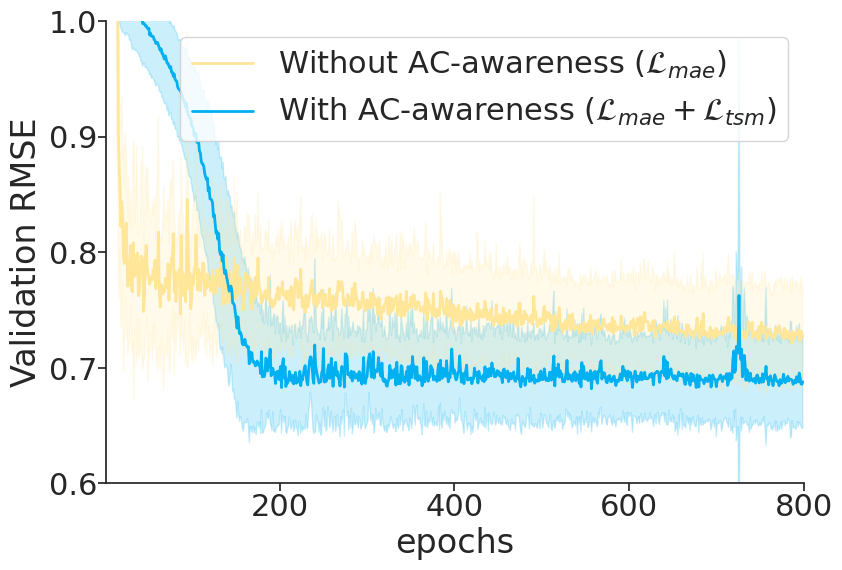

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

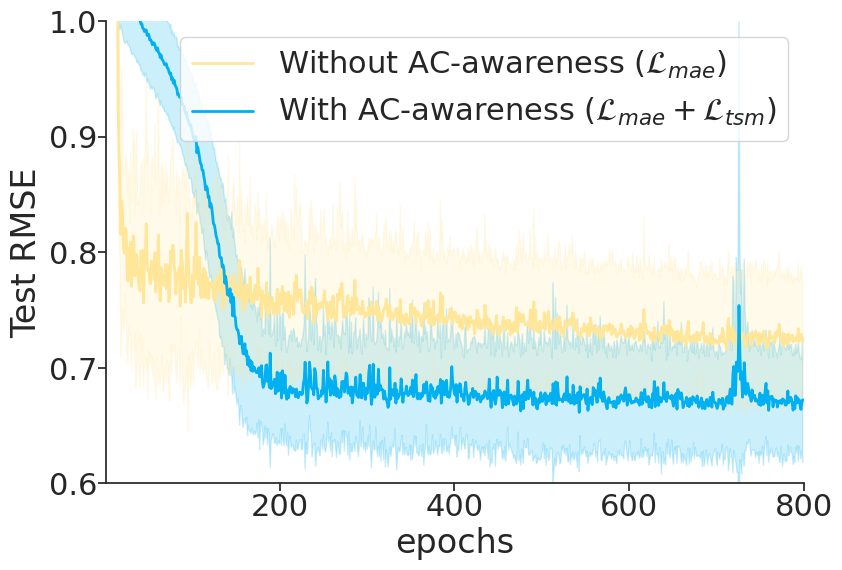

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

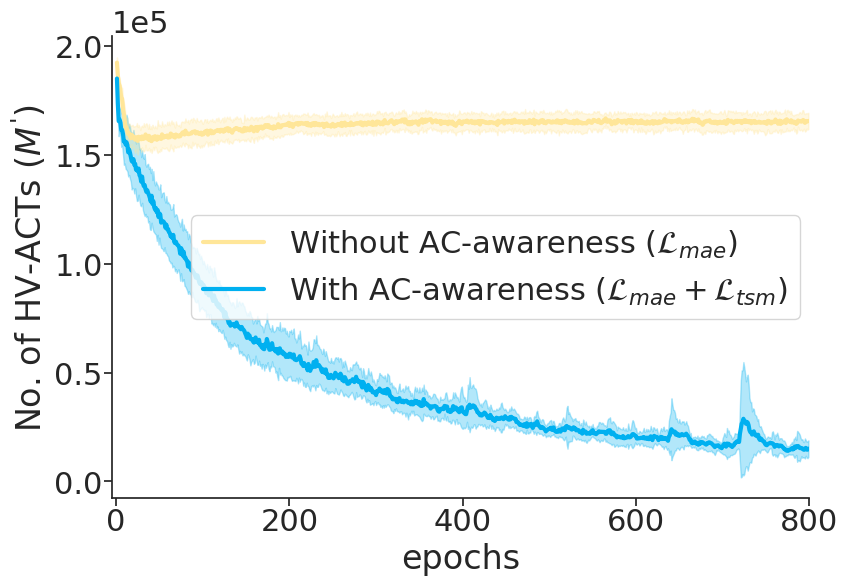

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

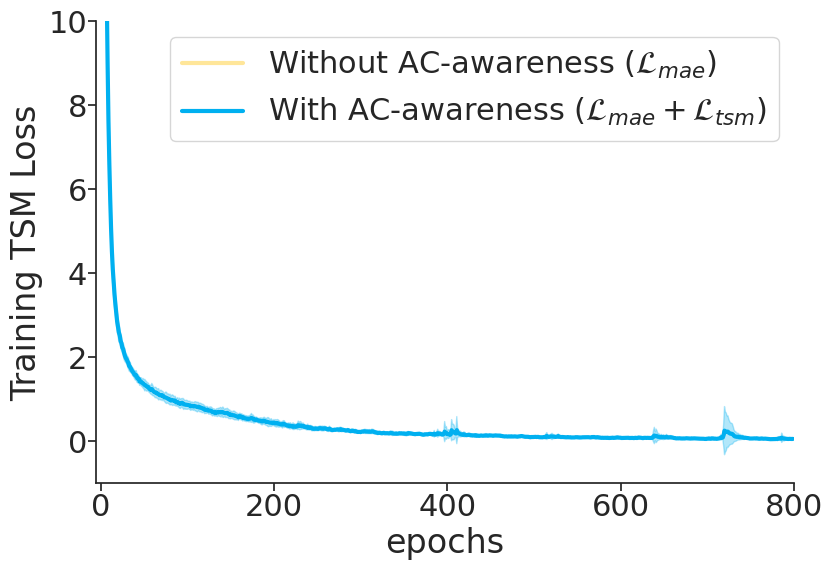

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

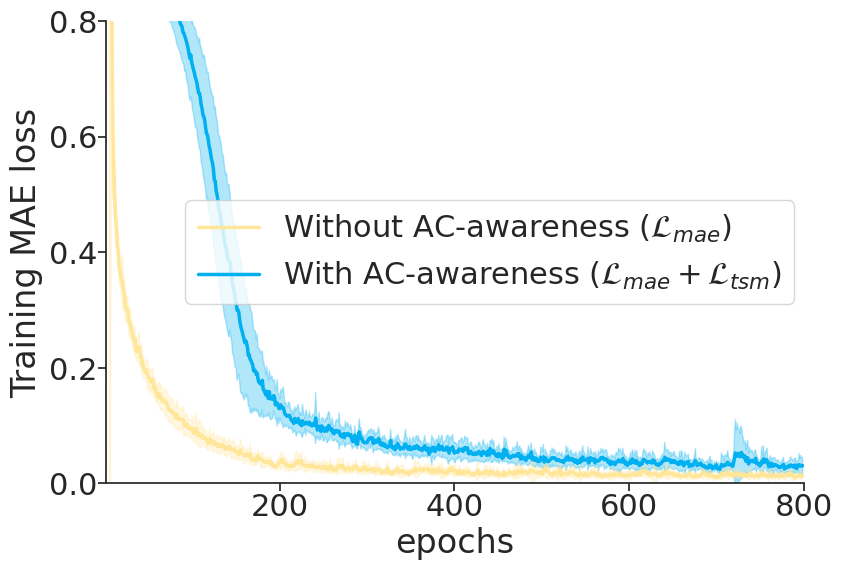

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 